In [147]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()

import csv
from scipy import stats
import os

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
posn_path = os.path.join(os.getcwd(), "performance_analytics","positions.xlsx")
idx_path = os.path.join(os.getcwd(), "performance_analytics","eth_index.csv")
val_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\val.csv"

In [149]:
hdata = HistData('ETH')
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
eth_idx = hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']]
eth_idx.index = [dt.strftime('%Y-%m-%d') for dt in eth_idx.index]
eth_idx.index.names = ['Date']
#eth_idx.to_csv(idx_path)

In [150]:
eth_idx.to_csv(idx_path)

In [151]:
eth_idx

,close
Date,
2023-12-31,2285.40
2024-01-01,2391.15
2024-01-02,2363.35
2024-01-03,2224.55
2024-01-04,2255.15
...,...
2024-03-27,3572.75
2024-03-28,3519.35
2024-03-29,3492.80


In [152]:
positions = pd.read_excel(posn_path,index_col = 0)
idx_px = pd.read_csv(idx_path,index_col = 0)
val = pd.read_csv(val_path,index_col = 0)

In [153]:
idx_px.index,positions.index = pd.to_datetime(idx_px.index),pd.to_datetime(positions.index,infer_datetime_format=True)
val.index = pd.to_datetime(val.index)

3000

In [160]:
latest_val = val.iloc[-1][0]
#dep = int(input())
dep = latest_val
latest_val = pd.DataFrame([dep],index = [pd.datetime.today().date()],columns = ['val'])

In [173]:
start_dt = val.index[0]
skeleton = pd.DataFrame(index = pd.date_range(start_dt,pd.datetime.today()),columns = ['val'])
val = val.reindex_like(skeleton).fillna(method = 'ffill')
val.to_csv(val_path)

with open(val_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(latest_val)):
        temp = latest_val.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [174]:
val = pd.read_csv(val_path,index_col = 0)
val

,val
2024-01-01,3000.0
2024-01-02,3000.0
2024-01-03,3000.0
2024-01-04,3000.0
2024-01-05,3000.0
...,...
2024-03-27,3000.0
2024-03-28,3000.0
2024-03-29,3000.0
2024-03-30,3000.0


In [175]:
#idx_px.index = [dt.strftime('%Y/%d/%') for dt in pd.to_datetime(idx_px.index)]
#positions.index = [dt.strftime('%Y-%d-%d') for dt in pd.to_datetime(positions.index)]

idx_px.index.names,positions.index.names = ['Date'],['Date']

In [176]:
usd_rets = positions.join(idx_px,on='Date',how = 'left')
usd_rets['Tactical Beta Convexity'] = usd_rets['close'].diff()*usd_rets['positions']

In [177]:
usd_rets = usd_rets.dropna()
usd_rets.dropna()

,positions,close,Tactical Beta Convexity
Date,,,
2024-01-02,0.80000,2363.35,-22.240000
2024-01-03,0.80000,2224.55,-111.040000
2024-01-04,0.80000,2255.15,24.480000
2024-01-05,0.80000,2233.35,-17.440000
2024-01-06,0.80000,2250.25,13.520000
...,...,...,...
2024-03-25,0.83152,3639.25,161.980096
2024-03-26,0.83152,3569.35,-58.123248
2024-03-27,0.83152,3572.75,2.827168


In [178]:
vol_float_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\floating_rets.csv"
vol_rel_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\realized_rets.csv"

In [179]:
vol_float_rets = pd.read_csv(vol_float_pnl_path,index_col = 0)
vol_rel_rets = pd.read_csv(vol_rel_pnl_path,index_col = 0)
vol_rel_rets = vol_rel_rets.groupby(vol_rel_rets.index).sum()

In [180]:

#vol_float_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_float_rets.index,format = "%d/%m/%Y")]
#vol_rel_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rel_rets.index,format = "%Y-%m-%d")]

In [181]:
vol_float_rets

,PnL
Date,
2024-02-01,0.000000
2024-02-02,0.000000
2024-02-03,0.000000
2024-02-04,0.000000
2024-02-05,0.000000
2024-02-06,0.000000
2024-02-07,0.000000
2024-02-08,0.000000
2024-02-09,0.000000


In [182]:
vol_rets = pd.DataFrame(pd.concat([vol_float_rets,vol_rel_rets],axis=1).sum(axis=1),columns = ['Short Volatility'])
vol_rets

,Short Volatility
Date,
2024-02-01,0.000000
2024-02-02,0.000000
2024-02-03,0.000000
2024-02-04,0.000000
2024-02-05,0.000000
2024-02-06,0.000000
2024-02-07,0.000000
2024-02-08,0.000000
2024-02-09,0.000000


In [183]:
curr_px = usd_rets['close'].iloc[-1]
vol_rets = vol_rets*curr_px

In [184]:
convexity = usd_rets[['Tactical Beta Convexity']]
convexity.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(convexity.index)]

In [185]:
convexity

,Tactical Beta Convexity
2024-01-02,-22.240000
2024-01-03,-111.040000
2024-01-04,24.480000
2024-01-05,-17.440000
2024-01-06,13.520000
...,...
2024-03-25,161.980096
2024-03-26,-58.123248
2024-03-27,2.827168
2024-03-28,-44.403168


In [186]:
vol_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rets.index)]

In [187]:
usd_rets

,positions,close,Tactical Beta Convexity
Date,,,
2024-01-02,0.80000,2363.35,-22.240000
2024-01-03,0.80000,2224.55,-111.040000
2024-01-04,0.80000,2255.15,24.480000
2024-01-05,0.80000,2233.35,-17.440000
2024-01-06,0.80000,2250.25,13.520000
...,...,...,...
2024-03-25,0.83152,3639.25,161.980096
2024-03-26,0.83152,3569.35,-58.123248
2024-03-27,0.83152,3572.75,2.827168


In [188]:
usd_rets = pd.concat([convexity,vol_rets],axis=1).fillna(0)

In [189]:

usd_rets['Total'] = usd_rets['Tactical Beta Convexity']+usd_rets['Short Volatility']
usd_rets.index.names = ["Date"]

<Axes: xlabel='Date'>

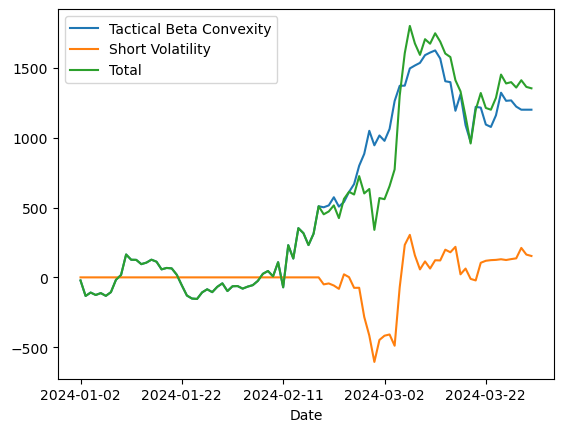

In [190]:
usd_rets.cumsum().plot()

In [191]:
val.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(val.index)]
vals = pd.concat([usd_rets,val],axis=1)['val']

In [192]:
usd_rets = pd.concat([usd_rets.cumsum(),val],axis=1).dropna()

In [193]:
for col in usd_rets.columns:
    usd_rets[col]=usd_rets[col]+usd_rets['val']



In [194]:
usd_rets.index = pd.to_datetime(usd_rets.index)

In [195]:
usd_rets = usd_rets[['Total','Short Volatility','Tactical Beta Convexity']]

In [196]:
eth_idx.index = pd.to_datetime(eth_idx.index)

In [197]:
usd_rets = pd.concat([usd_rets,eth_idx],axis=1).fillna(method = 'ffill')

In [198]:
usd_rets.columns = ['Total','Short Volatility','Tactical Beta Convexity','Index']

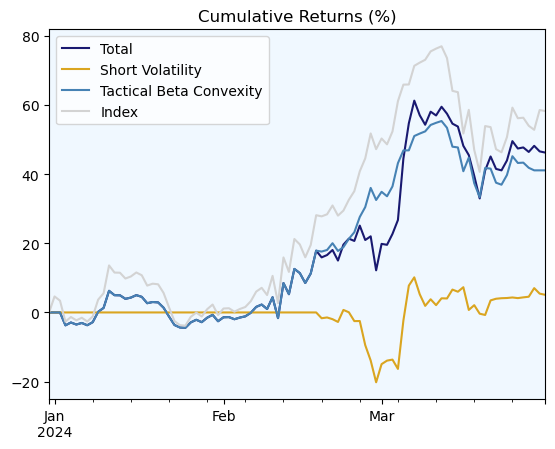

In [199]:
plot = (((1+(usd_rets.pct_change()).fillna(0)).cumprod()-1)*100).plot(title = 'Cumulative Returns (%)',color = ['midnightblue','goldenrod','steelblue','lightgrey'])
#(((1+eth_idx.pct_change()).cumprod()-1)*100).plot()
plot.set_facecolor('aliceblue')
picpath = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\MasterFundPerformance.png"
plot.get_figure().savefig(picpath)

In [200]:
rets = usd_rets[['Total']].pct_change().fillna(0)

In [201]:
np.sqrt(252)* rets.mean()/rets.std()

Total    2.298145
dtype: float64

<Axes: title={'center': 'Master Fund Expanding-Window Sharpe Ratio'}>

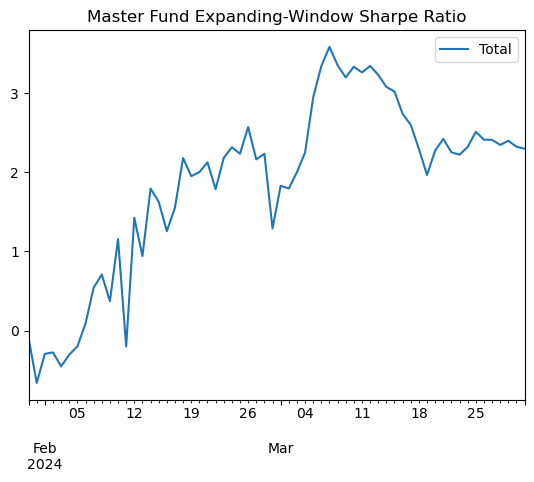

In [202]:
(np.sqrt(252)* rets.expanding().mean()/rets.expanding().std())[30:].plot(title = 'Master Fund Expanding-Window Sharpe Ratio')